# Data preprocessing

In [1]:
import os
if os.path.exists('/content/drive/MyDrive/data'):
  print("The 'data' folder exists")
else:
  print("The 'data' folder does not exist")

The 'data' folder does not exist


In [2]:
import os
if os.path.exists('/content/drive/MyDrive/newData'):
  print("The 'newData' folder exists")
else:
  print("The 'newData' folder does not exist")

The 'newData' folder does not exist


In [3]:
import os
import numpy as np
import torch
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, make_scorer
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, classification_report, f1_score, top_k_accuracy_score
import matplotlib.pyplot as plt

In [4]:
torch.manual_seed(0)

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [6]:
from sklearn.manifold import TSNE

def visualize_tsne(model, dataset, loader, device, batch_size=64):
    """
    Computes embeddings for all samples in dataset using CNN,
    then runs t-SNE and plots a 2D scatter plot
    """
    model.eval()
    loader = loader
    embeddings = []
    labels = []

    #Compute embeddings from the model
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            emb = model(x).cpu().numpy()
            embeddings.append(emb)
            labels.extend(y.numpy())

    embeddings = np.vstack(embeddings)
    labels = np.array(labels)


    tsne = TSNE(n_components=2, random_state=42)
    emb2d = tsne.fit_transform(embeddings)

    plt.figure()
    for lab in np.unique(labels):
        idx = labels == lab
        plt.scatter(emb2d[idx, 0], emb2d[idx, 1], label=str(lab))
    plt.legend(title='Class')
    plt.title('t-SNE of CNN Embeddings')
    plt.xlabel('t-SNE dimension 1')
    plt.ylabel('t-SNE dimension 2')
    plt.show()

In [7]:
#Triplet loss
def pairwise_distance(embeddings, squared=False):
    """Compute pairwise distances between embeddings"""
    dot = embeddings @ embeddings.t()
    square_norm = dot.diag()
    distances = square_norm.unsqueeze(1) - 2 * dot + square_norm.unsqueeze(0)
    distances = torch.clamp(distances, min=0.0)
    if not squared:
        mask = distances == 0.0
        distances = distances + mask * 1e-16
        distances = torch.sqrt(distances)
        distances = distances * (~mask)
    return distances

def get_triplet_mask(labels):
    """Returns mask where mask[a,p,n] is True for valid anchor-positive-negative triplets."""
    device = labels.device
    batch_size = labels.size(0)
    labels_equal = labels.unsqueeze(0) == labels.unsqueeze(1)#[N, N]
    indices_not_equal = ~torch.eye(batch_size, dtype=torch.bool, device=device)
    valid_ap = labels_equal & indices_not_equal  # anchor and positive
    valid_an = ~labels_equal # anchor and negative
    mask = valid_ap.unsqueeze(2) & valid_an.unsqueeze(1)#[N, N, N]
    return mask

In [8]:
def batch_semi_hard_triplet_loss(embeddings, labels, margin=2, squared=False):
    """
    Compute semi-hard triplet loss:
    For each anchor, choose positives with same label and negatives with different label
    where negative distance > positive distance but within margin.
    """
    pairwise_dist = pairwise_distance(embeddings, squared=squared)
    ap_dist = pairwise_dist.unsqueeze(2)  # [N, N, 1]
    an_dist = pairwise_dist.unsqueeze(1)  # [N, 1, N]

    triplet_loss = ap_dist - an_dist + margin

    mask = get_triplet_mask(labels).to(embeddings.device)
    triplet_loss = triplet_loss * mask

    triplet_loss = torch.clamp(triplet_loss, min=0.0)

    valid_triplets = triplet_loss > 1e-16
    num_positive = valid_triplets.sum().float()
    triplet_loss_sum = triplet_loss.sum()
    loss = triplet_loss_sum / (num_positive + 1e-16)
    return loss

In [10]:
def get_anchor_positive_mask(labels):
    device = labels.device
    indices_equal = torch.eye(labels.size(0), dtype=torch.bool, device=device)
    return (labels.unsqueeze(0) == labels.unsqueeze(1)) & ~indices_equal

def get_anchor_negative_mask(labels):
    return labels.unsqueeze(0) != labels.unsqueeze(1)

def batch_hard_triplet_loss(embeddings, labels, margin=2., squared=False):
    pairwise_dist = pairwise_distance(embeddings, squared=squared)

    mask_ap = get_anchor_positive_mask(labels).float()
    mask_an = get_anchor_negative_mask(labels).float()

    hardest_positive_dist = (pairwise_dist * mask_ap).max(dim=1)[0]
    max_dist = pairwise_dist.max().item()
    masked_neg_dist = pairwise_dist + max_dist * (1.0 - mask_an)
    hardest_negative_dist = masked_neg_dist.min(dim=1)[0]

    loss = torch.clamp(hardest_positive_dist - hardest_negative_dist + margin, min=0.0)
    return loss.mean()

In [11]:
def compute_triplet_loss(embeddings, labels, margin=2.0, mode='semi_hard', squared=False):
    if mode == 'hard':
        return batch_hard_triplet_loss(embeddings, labels, margin, squared)
    elif mode == 'semi_hard':
        return batch_semi_hard_triplet_loss(embeddings, labels, margin, squared)
    else:
        raise ValueError(f"Unknown triplet loss mode: {mode}")

In [12]:
def validate_embedding_quality(model, val_loader, device, k=20):
    model.eval()
    all_embs = []
    all_labels = []

    with torch.no_grad():
        for x, y in val_loader:
            x = x.to(device)
            emb = model(x)
            emb = F.normalize(emb, p=2, dim=1)
            all_embs.append(emb.cpu())
            all_labels.append(y)

    all_embs = torch.cat(all_embs)
    all_labels = torch.cat(all_labels)

    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(all_embs, all_labels)
    acc = knn.score(all_embs, all_labels)
    return acc

In [13]:
def train_semi_hard(model, loader, optimizer, device, val_loader=None, k=10, epochs=5, mode='semi_hard'):
    for ep in range(1, epochs + 1):
        model.train()
        total_loss = 0.0
        for x, y in tqdm(loader, desc=f"Epoch {ep}/{epochs}"):
            x, y = x.to(device), y.to(device)
            emb = model(x)
            loss = compute_triplet_loss(emb, y, margin=2, mode=mode)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item() * x.size(0)
        avg_loss = total_loss / len(loader.dataset)
        print(f"Epoch {ep} Avg Loss: {avg_loss:.4f}")

        #if validation dataset is present
        if val_loader is not None:
            val_acc = validate_embedding_quality(model, val_loader, device, k)
            print(f"Validation k-NN Accuracy: {val_acc:.4f}")

In [14]:
#Class to receive data from the data folders
class AdmixtureDataset(Dataset):
    def __init__(self, root_dir):
        self.samples = []
        self.labels = []
        folders = sorted([d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))],
                         key=lambda x: int(x))
        self.label_map = {folder: idx for idx, folder in enumerate(folders)}
        for folder in folders:
            lab = self.label_map[folder]
            folder_path = os.path.join(root_dir, folder)
            for fname in os.listdir(folder_path):
                if not fname.endswith(".txt"): #take only txt file because sometimes zips were present in the folder
                    continue
                arr = np.loadtxt(os.path.join(folder_path, fname), delimiter="\t", usecols=(1,2,3,4,5,6), dtype=np.float32) #We dont take the first column
                arr = np.nan_to_num(arr, nan=0.0).T #[6, 1000]
                self.samples.append(arr)
                self.labels.append(lab)

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        x = torch.from_numpy(self.samples[idx])
        y = torch.tensor(self.labels[idx], dtype=torch.long)
        return x, y

In [15]:
class CNNEmbedding(nn.Module):
    def __init__(self, embedding_dim=64):
        super().__init__()
        self.conv = nn.Sequential( #convolutional layers
            nn.Conv1d(6, 32, 7, padding=3),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.MaxPool1d(2),

            nn.Conv1d(32, 64, 5, padding=2),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.MaxPool1d(2),

            nn.Conv1d(64, 128, 5, padding=2),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.MaxPool1d(2),

            #Additional layer maybe comment out
            nn.Conv1d(128, 256, 3, padding=1),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.MaxPool1d(2),

            nn.Conv1d(256, 512, 3, padding=1),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(1)
        )


        self.fc = nn.Sequential( #fully connected layers
            nn.Flatten(),
            nn.Dropout(0.4),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(512, embedding_dim),
            nn.ReLU()
        )

    def forward(self, x):
        h = self.conv(x)   #[B,512,1]
        emb = self.fc(h)   #[B,embedding_dim]
        return emb

In [16]:
def evaluate_knn(model, dataset, loader, device):
    model.eval()
    embs, labs = [], []
    loader = loader
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            emb = model(x).cpu().numpy()
            embs.append(emb)
            labs.extend(y.numpy())
    embs = np.vstack(embs)





    
    Xtr, Xte, ytr, yte = train_test_split(embs, labs, test_size=0.2, stratify=labs, random_state=42)




    
    knn = KNeighborsClassifier(n_neighbors=20)
    knn.fit(Xtr, ytr)
    y_pred = knn.predict(Xte)

    #knn accuracy
    acc = accuracy_score(yte, y_pred)
    print(f"\n k‑NN classification accuracy: {acc:.4f}")

    print("\nClassification Report:")
    print(classification_report(yte, y_pred, digits=4,
          target_names=[str(k) for k in dataset.label_map.keys()]))

    #Confusion matrix
    cm = confusion_matrix(yte, y_pred)
    print("\nConfusion Matrix:")
    print(cm)

    return yte, y_pred

In [17]:
def evaluate_knn_with_elbow_cv(model, dataset, loader, device, max_k=100, cv_folds=30, random_state=42):
    model.eval()
    embs, labs = [], []
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            emb = model(x).cpu().numpy()
            embs.append(emb)
            labs.extend(y.numpy())
    embs = np.vstack(embs)
    labs = np.array(labs)


    f1_list = []
    k_range = range(1, max_k + 1)
    skf = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=random_state)
    scorer = make_scorer(f1_score, average='macro')

    for k in k_range:
        knn = KNeighborsClassifier(n_neighbors=k)
        scores = cross_val_score(knn, embs, labs, scoring=scorer, cv=skf, n_jobs=-1)
        f1_list.append(np.mean(scores))


    plt.figure(figsize=(8, 5))
    plt.plot(k_range, f1_list, marker="o")
    plt.xlabel("Number of Neighbors k")
    plt.ylabel("Cross-validated F1 Macro")
    plt.title(f"Elbow Method (CV F1 Macro over {cv_folds} folds)")
    plt.grid(True)
    plt.show()

    best_k = np.argmax(f1_list) + 1
    print(f"Best k by cross-validated F1 Macro: {best_k}")


    Xtr, Xte, ytr, yte = train_test_split(embs, labs, test_size=0.2, stratify=labs, random_state=random_state)
    knn = KNeighborsClassifier(n_neighbors=best_k)
    knn.fit(Xtr, ytr)
    y_pred = knn.predict(Xte)

    f1_macro = f1_score(yte, y_pred, average="macro")
    print(f"\nHold-out F1 Macro (k={best_k}): {f1_macro:.4f}")

    print("\nClassification Report:")
    print(classification_report(yte, y_pred, digits=4,
          target_names=[str(k) for k in dataset.label_map.keys()]))

    cm = confusion_matrix(yte, y_pred)
    print("\nConfusion Matrix:")
    print(cm)

    return yte, y_pred, k_range, f1_list

In [18]:
def split_dataset(dataset, val_ratio=0.2):
    labels = dataset.labels
    splitter = StratifiedShuffleSplit(n_splits=1, test_size=val_ratio, random_state=42)
    indices = list(range(len(labels)))
    for train_idx, val_idx in splitter.split(indices, labels):
        train_subset = torch.utils.data.Subset(dataset, train_idx)
        val_subset = torch.utils.data.Subset(dataset, val_idx)
        return train_subset, val_subset

# CNN

train dataset size: 10570
full dataset size: 13212


Epoch 1/40: 100%|██████████████████████████████████████████████████████████████████████| 83/83 [00:02<00:00, 36.32it/s]


Epoch 1 Avg Loss: 1.8593
Validation k-NN Accuracy: 0.3212


Epoch 2/40: 100%|██████████████████████████████████████████████████████████████████████| 83/83 [00:01<00:00, 42.02it/s]


Epoch 2 Avg Loss: 2.0107
Validation k-NN Accuracy: 0.3099


Epoch 3/40: 100%|██████████████████████████████████████████████████████████████████████| 83/83 [00:01<00:00, 42.36it/s]


Epoch 3 Avg Loss: 2.0139
Validation k-NN Accuracy: 0.3190


Epoch 4/40: 100%|██████████████████████████████████████████████████████████████████████| 83/83 [00:01<00:00, 42.43it/s]


Epoch 4 Avg Loss: 2.0024
Validation k-NN Accuracy: 0.3171


Epoch 5/40: 100%|██████████████████████████████████████████████████████████████████████| 83/83 [00:01<00:00, 42.41it/s]


Epoch 5 Avg Loss: 1.9969
Validation k-NN Accuracy: 0.3220


Epoch 6/40: 100%|██████████████████████████████████████████████████████████████████████| 83/83 [00:01<00:00, 42.76it/s]


Epoch 6 Avg Loss: 1.9956
Validation k-NN Accuracy: 0.3163


Epoch 7/40: 100%|██████████████████████████████████████████████████████████████████████| 83/83 [00:01<00:00, 42.80it/s]


Epoch 7 Avg Loss: 1.9820
Validation k-NN Accuracy: 0.3216


Epoch 8/40: 100%|██████████████████████████████████████████████████████████████████████| 83/83 [00:01<00:00, 42.27it/s]


Epoch 8 Avg Loss: 1.9886
Validation k-NN Accuracy: 0.3148


Epoch 9/40: 100%|██████████████████████████████████████████████████████████████████████| 83/83 [00:01<00:00, 42.33it/s]


Epoch 9 Avg Loss: 1.9900
Validation k-NN Accuracy: 0.3288


Epoch 10/40: 100%|█████████████████████████████████████████████████████████████████████| 83/83 [00:01<00:00, 42.08it/s]


Epoch 10 Avg Loss: 1.9853
Validation k-NN Accuracy: 0.3227


Epoch 11/40: 100%|█████████████████████████████████████████████████████████████████████| 83/83 [00:01<00:00, 42.35it/s]


Epoch 11 Avg Loss: 1.9849
Validation k-NN Accuracy: 0.3227


Epoch 12/40: 100%|█████████████████████████████████████████████████████████████████████| 83/83 [00:01<00:00, 42.38it/s]


Epoch 12 Avg Loss: 1.9778
Validation k-NN Accuracy: 0.3280


Epoch 13/40: 100%|█████████████████████████████████████████████████████████████████████| 83/83 [00:01<00:00, 42.42it/s]


Epoch 13 Avg Loss: 1.9839
Validation k-NN Accuracy: 0.3277


Epoch 14/40: 100%|█████████████████████████████████████████████████████████████████████| 83/83 [00:01<00:00, 42.21it/s]


Epoch 14 Avg Loss: 1.9933
Validation k-NN Accuracy: 0.3201


Epoch 15/40: 100%|█████████████████████████████████████████████████████████████████████| 83/83 [00:01<00:00, 41.99it/s]


Epoch 15 Avg Loss: 1.9804
Validation k-NN Accuracy: 0.3258


Epoch 16/40: 100%|█████████████████████████████████████████████████████████████████████| 83/83 [00:01<00:00, 42.22it/s]


Epoch 16 Avg Loss: 1.9873
Validation k-NN Accuracy: 0.3246


Epoch 17/40: 100%|█████████████████████████████████████████████████████████████████████| 83/83 [00:01<00:00, 42.62it/s]


Epoch 17 Avg Loss: 1.9898
Validation k-NN Accuracy: 0.3299


Epoch 18/40: 100%|█████████████████████████████████████████████████████████████████████| 83/83 [00:01<00:00, 42.46it/s]


Epoch 18 Avg Loss: 1.9844
Validation k-NN Accuracy: 0.3224


Epoch 19/40: 100%|█████████████████████████████████████████████████████████████████████| 83/83 [00:01<00:00, 42.27it/s]


Epoch 19 Avg Loss: 1.9927
Validation k-NN Accuracy: 0.3178


Epoch 20/40: 100%|█████████████████████████████████████████████████████████████████████| 83/83 [00:01<00:00, 42.57it/s]


Epoch 20 Avg Loss: 1.9879
Validation k-NN Accuracy: 0.3379


Epoch 21/40: 100%|█████████████████████████████████████████████████████████████████████| 83/83 [00:01<00:00, 42.49it/s]


Epoch 21 Avg Loss: 1.9843
Validation k-NN Accuracy: 0.3367


Epoch 22/40: 100%|█████████████████████████████████████████████████████████████████████| 83/83 [00:01<00:00, 42.20it/s]


Epoch 22 Avg Loss: 1.9811
Validation k-NN Accuracy: 0.3174


Epoch 23/40: 100%|█████████████████████████████████████████████████████████████████████| 83/83 [00:01<00:00, 42.14it/s]


Epoch 23 Avg Loss: 1.9994
Validation k-NN Accuracy: 0.3273


Epoch 24/40: 100%|█████████████████████████████████████████████████████████████████████| 83/83 [00:01<00:00, 41.75it/s]


Epoch 24 Avg Loss: 1.9816
Validation k-NN Accuracy: 0.3201


Epoch 25/40: 100%|█████████████████████████████████████████████████████████████████████| 83/83 [00:02<00:00, 41.47it/s]


Epoch 25 Avg Loss: 1.9994
Validation k-NN Accuracy: 0.3208


Epoch 26/40: 100%|█████████████████████████████████████████████████████████████████████| 83/83 [00:01<00:00, 41.69it/s]


Epoch 26 Avg Loss: 1.9878
Validation k-NN Accuracy: 0.3224


Epoch 27/40: 100%|█████████████████████████████████████████████████████████████████████| 83/83 [00:01<00:00, 41.68it/s]


Epoch 27 Avg Loss: 1.9984
Validation k-NN Accuracy: 0.3216


Epoch 28/40: 100%|█████████████████████████████████████████████████████████████████████| 83/83 [00:01<00:00, 41.90it/s]


Epoch 28 Avg Loss: 1.9906
Validation k-NN Accuracy: 0.3224


Epoch 29/40: 100%|█████████████████████████████████████████████████████████████████████| 83/83 [00:01<00:00, 41.84it/s]


Epoch 29 Avg Loss: 1.9827
Validation k-NN Accuracy: 0.3292


Epoch 30/40: 100%|█████████████████████████████████████████████████████████████████████| 83/83 [00:02<00:00, 40.06it/s]


Epoch 30 Avg Loss: 1.9946
Validation k-NN Accuracy: 0.3156


Epoch 31/40: 100%|█████████████████████████████████████████████████████████████████████| 83/83 [00:02<00:00, 40.08it/s]


Epoch 31 Avg Loss: 1.9886
Validation k-NN Accuracy: 0.3269


Epoch 32/40: 100%|█████████████████████████████████████████████████████████████████████| 83/83 [00:02<00:00, 41.23it/s]


Epoch 32 Avg Loss: 1.9898
Validation k-NN Accuracy: 0.3269


Epoch 33/40: 100%|█████████████████████████████████████████████████████████████████████| 83/83 [00:02<00:00, 41.05it/s]


Epoch 33 Avg Loss: 1.9820
Validation k-NN Accuracy: 0.3292


Epoch 34/40: 100%|█████████████████████████████████████████████████████████████████████| 83/83 [00:02<00:00, 41.07it/s]


Epoch 34 Avg Loss: 1.9870
Validation k-NN Accuracy: 0.3186


Epoch 35/40: 100%|█████████████████████████████████████████████████████████████████████| 83/83 [00:02<00:00, 41.03it/s]


Epoch 35 Avg Loss: 2.0049
Validation k-NN Accuracy: 0.3243


Epoch 36/40: 100%|█████████████████████████████████████████████████████████████████████| 83/83 [00:02<00:00, 41.29it/s]


Epoch 36 Avg Loss: 1.9872
Validation k-NN Accuracy: 0.3212


Epoch 37/40: 100%|█████████████████████████████████████████████████████████████████████| 83/83 [00:02<00:00, 41.39it/s]


Epoch 37 Avg Loss: 1.9900
Validation k-NN Accuracy: 0.3314


Epoch 38/40: 100%|█████████████████████████████████████████████████████████████████████| 83/83 [00:02<00:00, 41.36it/s]


Epoch 38 Avg Loss: 1.9954
Validation k-NN Accuracy: 0.3318


Epoch 39/40: 100%|█████████████████████████████████████████████████████████████████████| 83/83 [00:01<00:00, 41.55it/s]


Epoch 39 Avg Loss: 1.9941
Validation k-NN Accuracy: 0.3295


Epoch 40/40: 100%|█████████████████████████████████████████████████████████████████████| 83/83 [00:01<00:00, 41.59it/s]


Epoch 40 Avg Loss: 1.9861
Validation k-NN Accuracy: 0.3330


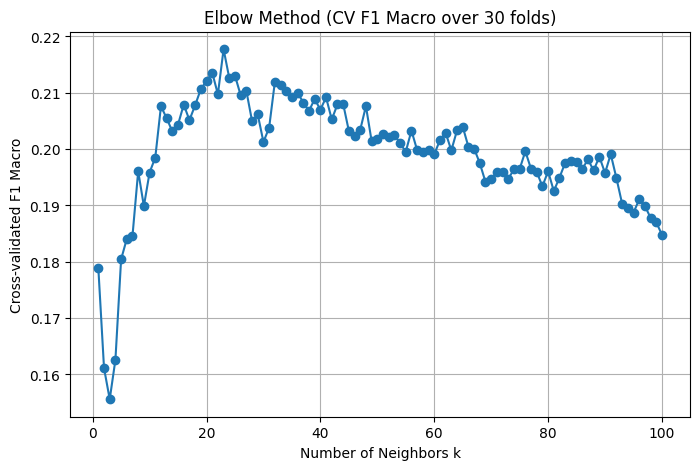

Best k by cross-validated F1 Macro: 23

Hold-out F1 Macro (k=23): 0.2187

Classification Report:
              precision    recall  f1-score   support

           3     0.5667    0.4595    0.5075        37
         100     0.4810    0.5352    0.5067        71
         300     0.1739    0.1600    0.1667        50
         500     0.1304    0.0638    0.0857        47
         700     0.2703    0.2326    0.2500        43
         900     0.0667    0.0500    0.0571        40
        1100     0.1714    0.1500    0.1600        40
        1300     0.1481    0.2667    0.1905        60
        1500     0.2165    0.3443    0.2658        61
        1700     0.1538    0.0513    0.0769        39
        1900     0.1613    0.1220    0.1389        41

    accuracy                         0.2420       529
   macro avg     0.2309    0.2214    0.2187       529
weighted avg     0.2378    0.2420    0.2323       529


Confusion Matrix:
[[17 13  3  2  0  0  0  0  2  0  0]
 [10 38 11  5  1  0  1  1  0  1  3]

In [22]:
def main(data_root, epochs=15, batch_size=64, lr=1e-4):
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    #Loading the dataset and splitting it
    full_ds = AdmixtureDataset(data_root)
    val_ratio = 0.2
    val_size = int(len(full_ds) * val_ratio)
    train_size = len(full_ds) - val_size
    train_ds, val_ds = split_dataset(full_ds, val_ratio=val_ratio)
    print("train dataset size:", train_size)
    print("full dataset size:",len(full_ds))



    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=0)
    
    val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=0)

    
    #Model train
    model = CNNEmbedding(embedding_dim=128).to(device)
    opt = torch.optim.Adam(model.parameters(), lr=lr)

    train_semi_hard(model, train_loader, opt, device, val_loader=val_loader, k=23, epochs=epochs, mode='semi_hard')

    #Final evaluation on full dataset
    mode = "semi_hard"
    y_true, y_pred, _, f1_list = evaluate_knn_with_elbow_cv(model, full_ds, val_loader, device)

    #Some predictions
    for true, pred in zip(y_true[:15], y_pred[:15]):
        print(f"True: {true}, Predicted: {pred}")

    #visualize
    # visualize_tsne(model, full_ds, val_loader, device)

if __name__ == "__main__":
    main(data_root="jupyterLabGeneratedData\\fullData", epochs=40, batch_size=128, lr=1e-5)

In [ ]:
import itertools

parameter_options = {
    'epochs': [2, 5, 10, 20],
    'batch_size': [16, 32, 64, 128],
    'lr': [1e-4, 2e-5, 1e-5, 3e-4]
}




def evaluate_parameters(epochs, batch_size, lr, model_class, ds, loader, visualization_fn, device):
    model = model_class(embedding_dim=64).to(device)
    opt = torch.optim.Adam(model.parameters(), lr=lr)

    train_semi_hard(model, loader, opt, device, epochs)
    acc, f1, top3, knn, X_train, y_train = evaluate_knn(model, ds, device)

    print(f"Parameters: Epochs: {epochs}, Batch Size: {batch_size}, Learning Rate: {lr}")
    print(f"Accuracy: {acc:.4f}, F1 Macro: {f1:.4f}, Top-3 Accuracy: {top3:.4f}")

    if visualization_fn:
        visualization_fn(model, ds, device)

    return acc, f1, top3

best_f1 = -np.inf
best_params = None

for param_combo in itertools.product(*parameter_options.values()):
    epochs, batch_size, lr = param_combo
    acc, f1, top3 = evaluate_parameters(epochs, batch_size, lr, CNNEmbedding, ds, loader, visualize_tsne, device)

    if f1 > best_f1:
        best_f1 = f1
        best_params = (epochs, batch_size, lr)

print(f"Best parameters: Epochs={best_params[0]}, Batch Size={best_params[1]}, Learning Rate={best_params[2]}")

# Real data prediction

In [25]:
file_path = "jupyterLabGeneratedData\\Tibetan_Denisova.txt"
tibets = pd.read_csv(file_path, sep="\t", header=None)

In [26]:
tibets[1].nunique()

22

In [27]:
tibets[0].nunique()

76

In [28]:
df = pd.read_csv(file_path, sep="\t", header=None, names=["ID", "Chromosome", "Start", "End"])

# Since EPAS1 haplotype is on second chromosome we need to filter it out
chr2_df = df[df["Chromosome"] == 2].copy()

In [29]:
chr2_df

,ID,Chromosome,Start,End
62,WGC022051D_1,2,25320094,25353963
63,WGC022051D_1,2,46460121,46461792
64,WGC022051D_1,2,71346671,71380297
65,WGC022051D_1,2,123719116,123770269
66,WGC022051D_1,2,142177714,142179938
...,...,...,...,...
9713,WGC022114D_2,2,79366818,79367657
9714,WGC022114D_2,2,142177714,142179938
9715,WGC022114D_2,2,218746689,218752956
9716,WGC022114D_2,2,221654920,221669371


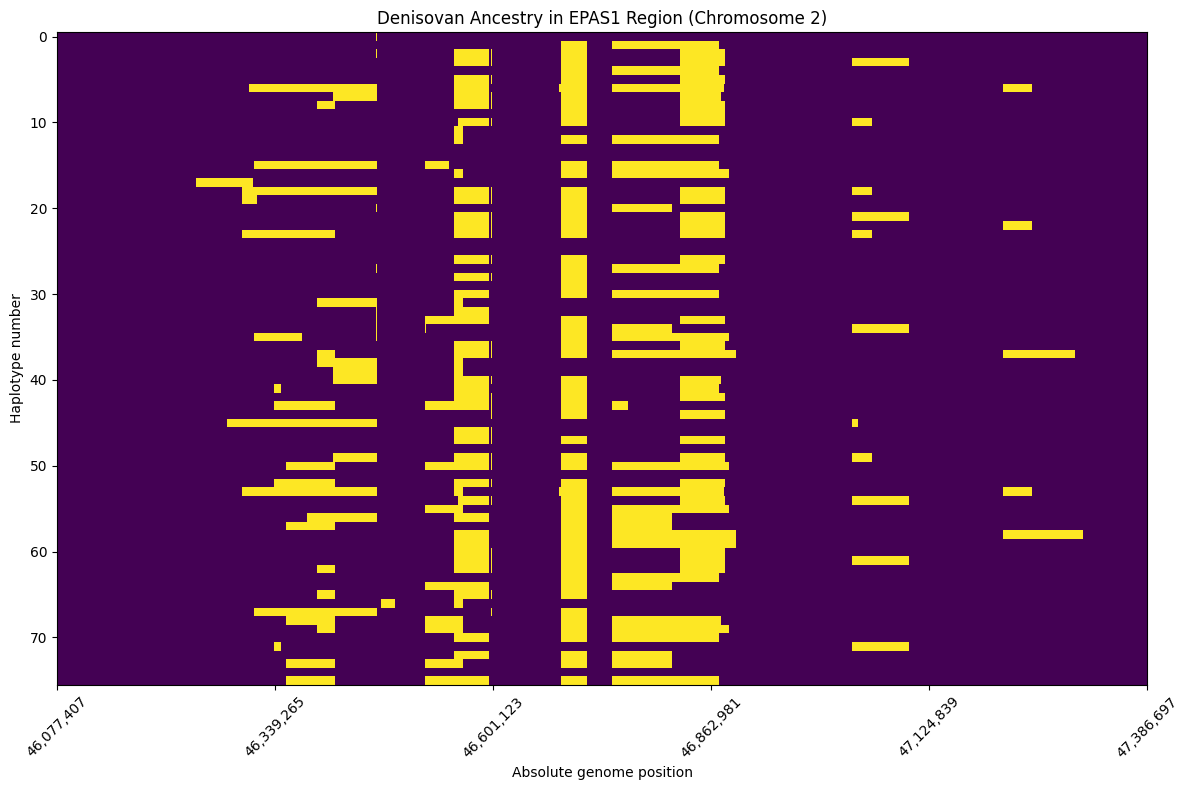

In [27]:
file_path = "jupyterLabGeneratedData\\Tibetan_Denisova.txt"
df = pd.read_csv(file_path, sep="\t", header=None, names=["ID", "Chromosome", "Start", "End"])

# Focus on chromosome 2
chr2_df = df[df["Chromosome"] == 2].copy()

# Define EPAS1 region
epas1_start = 46077407
epas1_end = 47386697
n_bins = 3000 


positions = np.linspace(epas1_start, epas1_end, n_bins)


individuals = sorted(chr2_df["ID"].unique())
individual_index = {id_: i for i, id_ in enumerate(individuals)}


heatmap = np.zeros((len(individuals), len(positions)), dtype=int)


for _, row in chr2_df.iterrows():
    if row["End"] < epas1_start or row["Start"] > epas1_end:
        continue
    i = individual_index[row["ID"]]
    covered = (positions >= row["Start"]) & (positions <= row["End"])
    heatmap[i, covered] = 1

# Plot
plt.figure(figsize=(12, 8))
plt.imshow(heatmap, aspect='auto', interpolation='none', cmap='viridis')
plt.xlabel("Absolute genome position")
plt.ylabel("Haplotype number")
plt.xticks(
    ticks=np.linspace(0, len(positions)-1, 6),
    labels=[f"{int(p):,}" for p in np.linspace(epas1_start, epas1_end , 6)],
    rotation=45
)
plt.title("Denisovan Ancestry in EPAS1 Region (Chromosome 2)")
plt.tight_layout()
plt.show()


In [9]:
chr_of_interest = "2"
interval_start = 46147912
interval_end = 46534660


matching_intervals = []
with open(file_path, "r") as f:
    for line in f:
        parts = line.strip().split("\t")
        if len(parts) < 4:
            continue
        person_id, chrom, start_str, end_str = parts[:4]
        if chrom != chr_of_interest:
            continue
        try:
            start = int(start_str)
            end = int(end_str)
        except ValueError:
            continue

        #сheck if the interval overlaps the target interval
        if start <= interval_end and end >= interval_start:
            matching_intervals.append((person_id, chrom, start, end))

matching_intervals[:10], len(matching_intervals)

([('WGC022051D_1', '2', 46460121, 46461792),
  ('WGC022052D_1', '2', 46460121, 46461792),
  ('WGC022054D_1', '2', 46307712, 46461792),
  ('WGC022054D_2', '2', 46409146, 46461792),
  ('WGC022055D_1', '2', 46388802, 46411311),
  ('WGC022058D_2', '2', 46314064, 46461792),
  ('WGC022058D_2', '2', 46519591, 46548350),
  ('WGC022059D_2', '2', 46243313, 46312062),
  ('WGC022060D_1', '2', 46298751, 46461792),
  ('WGC022060D_2', '2', 46298751, 46317104)],
 51)

In [11]:
overlaps_df = pd.read_csv("jupyterLabGeneratedData\\chr2_overlaps_full.txt", sep="\t", header=None, names=["ID", "chr", "start", "end"])
cm_df = pd.read_csv("jupyterLabGeneratedData\\centimorgan legnths.txt", sep="\t")


overlaps_df["cm"] = cm_df["cm"]

output_path = "jupyterLabGeneratedData\\chr2_overlaps_with_cm.txt"
overlaps_df.to_csv(output_path, sep="\t", index=False)

output_path


'jupyterLabGeneratedData\\chr2_overlaps_with_cm.txt'

In [15]:
region_start = 46147912
region_end = 46534660
region_length = region_end - region_start
num_bins = 1000
bin_size = (region_length) / num_bins


region_cm = 1.0
bin_size_cm = region_cm / num_bins


df = pd.read_csv('jupyterLabGeneratedData\\chr2_overlaps_with_cm.txt', sep="\t")


person_tracts = {}
for row in df.itertuples(index=False):
    pid = row.ID
    s = row.start
    e = row.end
    c = row.cm
    if pid not in person_tracts:
        person_tracts[pid] = []
    person_tracts[pid].append((s, e, c))

all_persons = sorted(person_tracts)
n_persons = len(all_persons)


results = []

for bin_idx in range(num_bins):
    bin_start = int(region_start + bin_idx * bin_size)
    bin_end = int(region_start + (bin_idx + 1) * bin_size)
    bin_mid = int((bin_start + bin_end) / 2)

    denisovan_base_counts = []
    denisovan_tract_lens = []
    tibetan_tract_lens = []
    denisovan_freq_count = 0

    for pid in all_persons:
        tracts = person_tracts[pid]
        covered_bases = 0
        overlapping_tract_lens = []
        for s, e, c in tracts:
            #overlap between tract and bin
            overlap_start = max(bin_start, s)
            overlap_end = min(bin_end, e)
            if overlap_start < overlap_end:
                overlap_bases = overlap_end - overlap_start
                covered_bases += overlap_bases

                
                overlapping_tract_lens.append(c)
        denisovan_base_counts.append(covered_bases)
        if covered_bases > 0:
            denisovan_freq_count += 1
            denisovan_tract_lens.append(overlapping_tract_lens[0] if overlapping_tract_lens else np.nan)
        else:
            # No Denisovan in the bin for this individual
            tibetan_tract_lens.append(bin_size_cm)


    
    #mean covered bases per person
    mean_denisovan_bases = np.mean(denisovan_base_counts)


    
    #fraction of people with Denisovan ancestry in this position of the chromosome
    freq_ancestry0_denisovan = denisovan_freq_count / n_persons
   
    
    
    #Mean and variance of tract lengths for Denisovan (ancestry 0)
    mean_tractlen_denisovan = np.mean(denisovan_tract_lens) if denisovan_tract_lens else np.nan
    var_tractlen_denisovan = np.var(denisovan_tract_lens, ddof=0) if denisovan_tract_lens else np.nan


    
    #Mean and variance of tract length for Tibetan (ancestry 1)
    mean_tractlen_tibetan = np.mean(tibetan_tract_lens) if tibetan_tract_lens else np.nan
    var_tractlen_tibetan = np.var(tibetan_tract_lens, ddof=0) if tibetan_tract_lens else np.nan




    
    results.append([
        bin_mid,
        mean_denisovan_bases,
        freq_ancestry0_denisovan,
        mean_tractlen_denisovan,
        mean_tractlen_tibetan,
        var_tractlen_denisovan,
        var_tractlen_tibetan
    ])







colnames = [
    "bin_mid_bp",
    "mean_denisovan_bases",
    "freq_ancestry0_denisovan",
    "mean_tractlen_ancestry0_denisovan_cm",
    "mean_tractlen_ancestry1_tibetan_cm",
    "var_tractlen_ancestry0_denisovan_cm",
    "var_tractlen_ancestry1_tibetan_cm"
]
result_df = pd.DataFrame(results, columns=colnames)
result_df.to_csv('jupyterLabGeneratedData\\per_bin_denisovan_tibetan_summary.csv', sep='\t', index=False)

Output written to per_bin_denisovan_tibetan_summary.csv


In [37]:
import csv

def convert_csv_to_txt(csv_file_path, txt_file_path):
    with open(csv_file_path, 'r', newline='') as csv_file, open(txt_file_path, 'w', newline='') as txt_file:
        csv_reader = csv.reader(csv_file)
        for row in csv_reader:
            txt_file.write('\t'.join(row) + '\n')

convert_csv_to_txt('jupyterLabGeneratedData\\per_bin_denisovan_tibetan_summary.csv', 'jupyterLabGeneratedData\\per_bin_denisovan.txt')

# Real Data prediction

In [33]:
def predict_single_file(model, file_path, device):
    #oad and preprocess the file
    arr = np.loadtxt(file_path, delimiter="\t", usecols=(0,1,2,3,4,5), dtype=np.float32)
    arr = np.nan_to_num(arr, nan=0.0).T  #[6, 1000]
    x = torch.from_numpy(arr).unsqueeze(0).to(device)  #[1, 6, 1000]


    model.eval()
    with torch.no_grad():
        embeddings = model(x)

        return embeddings


10570
13212


Epoch 1/100: 100%|█████████████████████████████████████████████████████████████████████| 83/83 [00:02<00:00, 37.44it/s]


Epoch 1 Avg Loss: 1.9440
Validation k-NN Accuracy: 0.3186


Epoch 2/100: 100%|█████████████████████████████████████████████████████████████████████| 83/83 [00:01<00:00, 43.03it/s]


Epoch 2 Avg Loss: 2.0198
Validation k-NN Accuracy: 0.3235


Epoch 3/100: 100%|█████████████████████████████████████████████████████████████████████| 83/83 [00:01<00:00, 42.96it/s]


Epoch 3 Avg Loss: 2.0042
Validation k-NN Accuracy: 0.3261


Epoch 4/100: 100%|█████████████████████████████████████████████████████████████████████| 83/83 [00:01<00:00, 42.88it/s]


Epoch 4 Avg Loss: 2.0009
Validation k-NN Accuracy: 0.3231


Epoch 5/100: 100%|█████████████████████████████████████████████████████████████████████| 83/83 [00:01<00:00, 42.80it/s]


Epoch 5 Avg Loss: 1.9945
Validation k-NN Accuracy: 0.3174


Epoch 6/100: 100%|█████████████████████████████████████████████████████████████████████| 83/83 [00:01<00:00, 42.92it/s]


Epoch 6 Avg Loss: 1.9865
Validation k-NN Accuracy: 0.3243


Epoch 7/100: 100%|█████████████████████████████████████████████████████████████████████| 83/83 [00:01<00:00, 42.65it/s]


Epoch 7 Avg Loss: 1.9822
Validation k-NN Accuracy: 0.3220


Epoch 8/100: 100%|█████████████████████████████████████████████████████████████████████| 83/83 [00:01<00:00, 42.81it/s]


Epoch 8 Avg Loss: 1.9877
Validation k-NN Accuracy: 0.3216


Epoch 9/100: 100%|█████████████████████████████████████████████████████████████████████| 83/83 [00:01<00:00, 42.80it/s]


Epoch 9 Avg Loss: 1.9826
Validation k-NN Accuracy: 0.3280


Epoch 10/100: 100%|████████████████████████████████████████████████████████████████████| 83/83 [00:01<00:00, 42.87it/s]


Epoch 10 Avg Loss: 1.9909
Validation k-NN Accuracy: 0.3261


Epoch 11/100: 100%|████████████████████████████████████████████████████████████████████| 83/83 [00:01<00:00, 42.60it/s]


Epoch 11 Avg Loss: 1.9859
Validation k-NN Accuracy: 0.3208


Epoch 12/100: 100%|████████████████████████████████████████████████████████████████████| 83/83 [00:01<00:00, 42.71it/s]


Epoch 12 Avg Loss: 1.9905
Validation k-NN Accuracy: 0.3280


Epoch 13/100: 100%|████████████████████████████████████████████████████████████████████| 83/83 [00:01<00:00, 42.69it/s]


Epoch 13 Avg Loss: 1.9887
Validation k-NN Accuracy: 0.3208


Epoch 14/100: 100%|████████████████████████████████████████████████████████████████████| 83/83 [00:01<00:00, 42.82it/s]


Epoch 14 Avg Loss: 1.9937
Validation k-NN Accuracy: 0.3254


Epoch 15/100: 100%|████████████████████████████████████████████████████████████████████| 83/83 [00:01<00:00, 42.81it/s]


Epoch 15 Avg Loss: 1.9846
Validation k-NN Accuracy: 0.3295


Epoch 16/100: 100%|████████████████████████████████████████████████████████████████████| 83/83 [00:01<00:00, 42.80it/s]


Epoch 16 Avg Loss: 1.9934
Validation k-NN Accuracy: 0.3280


Epoch 17/100: 100%|████████████████████████████████████████████████████████████████████| 83/83 [00:01<00:00, 42.73it/s]


Epoch 17 Avg Loss: 1.9912
Validation k-NN Accuracy: 0.3261


Epoch 18/100: 100%|████████████████████████████████████████████████████████████████████| 83/83 [00:01<00:00, 42.54it/s]


Epoch 18 Avg Loss: 1.9982
Validation k-NN Accuracy: 0.3295


Epoch 19/100: 100%|████████████████████████████████████████████████████████████████████| 83/83 [00:01<00:00, 42.51it/s]


Epoch 19 Avg Loss: 1.9914
Validation k-NN Accuracy: 0.3295


Epoch 20/100: 100%|████████████████████████████████████████████████████████████████████| 83/83 [00:01<00:00, 42.70it/s]


Epoch 20 Avg Loss: 1.9938
Validation k-NN Accuracy: 0.3337


Epoch 21/100: 100%|████████████████████████████████████████████████████████████████████| 83/83 [00:01<00:00, 42.43it/s]


Epoch 21 Avg Loss: 1.9954
Validation k-NN Accuracy: 0.3424


Epoch 22/100: 100%|████████████████████████████████████████████████████████████████████| 83/83 [00:01<00:00, 42.70it/s]


Epoch 22 Avg Loss: 1.9950
Validation k-NN Accuracy: 0.3307


Epoch 23/100: 100%|████████████████████████████████████████████████████████████████████| 83/83 [00:01<00:00, 42.66it/s]


Epoch 23 Avg Loss: 1.9951
Validation k-NN Accuracy: 0.3258


Epoch 24/100: 100%|████████████████████████████████████████████████████████████████████| 83/83 [00:01<00:00, 42.54it/s]


Epoch 24 Avg Loss: 1.9938
Validation k-NN Accuracy: 0.3318


Epoch 25/100: 100%|████████████████████████████████████████████████████████████████████| 83/83 [00:01<00:00, 42.67it/s]


Epoch 25 Avg Loss: 1.9896
Validation k-NN Accuracy: 0.3311


Epoch 26/100: 100%|████████████████████████████████████████████████████████████████████| 83/83 [00:01<00:00, 42.58it/s]


Epoch 26 Avg Loss: 2.0001
Validation k-NN Accuracy: 0.3292


Epoch 27/100: 100%|████████████████████████████████████████████████████████████████████| 83/83 [00:01<00:00, 42.55it/s]


Epoch 27 Avg Loss: 1.9948
Validation k-NN Accuracy: 0.3243


Epoch 28/100: 100%|████████████████████████████████████████████████████████████████████| 83/83 [00:01<00:00, 42.55it/s]


Epoch 28 Avg Loss: 1.9894
Validation k-NN Accuracy: 0.3314


Epoch 29/100: 100%|████████████████████████████████████████████████████████████████████| 83/83 [00:01<00:00, 42.55it/s]


Epoch 29 Avg Loss: 1.9940
Validation k-NN Accuracy: 0.3277


Epoch 30/100: 100%|████████████████████████████████████████████████████████████████████| 83/83 [00:01<00:00, 42.82it/s]


Epoch 30 Avg Loss: 2.0012
Validation k-NN Accuracy: 0.3284


Epoch 31/100: 100%|████████████████████████████████████████████████████████████████████| 83/83 [00:01<00:00, 42.53it/s]


Epoch 31 Avg Loss: 2.0002
Validation k-NN Accuracy: 0.3326


Epoch 32/100: 100%|████████████████████████████████████████████████████████████████████| 83/83 [00:01<00:00, 42.54it/s]


Epoch 32 Avg Loss: 1.9911
Validation k-NN Accuracy: 0.3269


Epoch 33/100: 100%|████████████████████████████████████████████████████████████████████| 83/83 [00:01<00:00, 42.70it/s]


Epoch 33 Avg Loss: 1.9882
Validation k-NN Accuracy: 0.3318


Epoch 34/100: 100%|████████████████████████████████████████████████████████████████████| 83/83 [00:01<00:00, 42.46it/s]


Epoch 34 Avg Loss: 1.9930
Validation k-NN Accuracy: 0.3348


Epoch 35/100: 100%|████████████████████████████████████████████████████████████████████| 83/83 [00:01<00:00, 42.44it/s]


Epoch 35 Avg Loss: 1.9970
Validation k-NN Accuracy: 0.3337


Epoch 36/100: 100%|████████████████████████████████████████████████████████████████████| 83/83 [00:01<00:00, 42.45it/s]


Epoch 36 Avg Loss: 2.0058
Validation k-NN Accuracy: 0.3337


Epoch 37/100: 100%|████████████████████████████████████████████████████████████████████| 83/83 [00:01<00:00, 42.17it/s]


Epoch 37 Avg Loss: 1.9885
Validation k-NN Accuracy: 0.3352


Epoch 38/100: 100%|████████████████████████████████████████████████████████████████████| 83/83 [00:01<00:00, 42.00it/s]


Epoch 38 Avg Loss: 1.9981
Validation k-NN Accuracy: 0.3231


Epoch 39/100: 100%|████████████████████████████████████████████████████████████████████| 83/83 [00:01<00:00, 41.89it/s]


Epoch 39 Avg Loss: 2.0010
Validation k-NN Accuracy: 0.3208


Epoch 40/100: 100%|████████████████████████████████████████████████████████████████████| 83/83 [00:01<00:00, 42.24it/s]


Epoch 40 Avg Loss: 1.9889
Validation k-NN Accuracy: 0.3337


Epoch 41/100: 100%|████████████████████████████████████████████████████████████████████| 83/83 [00:01<00:00, 42.11it/s]


Epoch 41 Avg Loss: 1.9936
Validation k-NN Accuracy: 0.3284


Epoch 42/100: 100%|████████████████████████████████████████████████████████████████████| 83/83 [00:01<00:00, 41.63it/s]


Epoch 42 Avg Loss: 1.9996
Validation k-NN Accuracy: 0.3280


Epoch 43/100: 100%|████████████████████████████████████████████████████████████████████| 83/83 [00:01<00:00, 41.88it/s]


Epoch 43 Avg Loss: 1.9952
Validation k-NN Accuracy: 0.3360


Epoch 44/100: 100%|████████████████████████████████████████████████████████████████████| 83/83 [00:01<00:00, 41.91it/s]


Epoch 44 Avg Loss: 1.9826
Validation k-NN Accuracy: 0.3250


Epoch 45/100: 100%|████████████████████████████████████████████████████████████████████| 83/83 [00:01<00:00, 41.96it/s]


Epoch 45 Avg Loss: 2.0056
Validation k-NN Accuracy: 0.3352


Epoch 46/100: 100%|████████████████████████████████████████████████████████████████████| 83/83 [00:01<00:00, 41.62it/s]


Epoch 46 Avg Loss: 1.9824
Validation k-NN Accuracy: 0.3314


Epoch 47/100: 100%|████████████████████████████████████████████████████████████████████| 83/83 [00:01<00:00, 41.92it/s]


Epoch 47 Avg Loss: 1.9993
Validation k-NN Accuracy: 0.3231


Epoch 48/100: 100%|████████████████████████████████████████████████████████████████████| 83/83 [00:01<00:00, 41.89it/s]


Epoch 48 Avg Loss: 1.9885
Validation k-NN Accuracy: 0.3314


Epoch 49/100: 100%|████████████████████████████████████████████████████████████████████| 83/83 [00:01<00:00, 41.54it/s]


Epoch 49 Avg Loss: 1.9926
Validation k-NN Accuracy: 0.3277


Epoch 50/100: 100%|████████████████████████████████████████████████████████████████████| 83/83 [00:01<00:00, 41.73it/s]


Epoch 50 Avg Loss: 2.0010
Validation k-NN Accuracy: 0.3435


Epoch 51/100: 100%|████████████████████████████████████████████████████████████████████| 83/83 [00:01<00:00, 41.88it/s]


Epoch 51 Avg Loss: 1.9905
Validation k-NN Accuracy: 0.3447


Epoch 52/100: 100%|████████████████████████████████████████████████████████████████████| 83/83 [00:01<00:00, 41.68it/s]


Epoch 52 Avg Loss: 1.9880
Validation k-NN Accuracy: 0.3326


Epoch 53/100: 100%|████████████████████████████████████████████████████████████████████| 83/83 [00:01<00:00, 42.01it/s]


Epoch 53 Avg Loss: 1.9950
Validation k-NN Accuracy: 0.3333


Epoch 54/100: 100%|████████████████████████████████████████████████████████████████████| 83/83 [00:01<00:00, 41.55it/s]


Epoch 54 Avg Loss: 1.9970
Validation k-NN Accuracy: 0.3367


Epoch 55/100: 100%|████████████████████████████████████████████████████████████████████| 83/83 [00:01<00:00, 41.71it/s]


Epoch 55 Avg Loss: 1.9934
Validation k-NN Accuracy: 0.3424


Epoch 56/100: 100%|████████████████████████████████████████████████████████████████████| 83/83 [00:01<00:00, 41.75it/s]


Epoch 56 Avg Loss: 1.9874
Validation k-NN Accuracy: 0.3405


Epoch 57/100: 100%|████████████████████████████████████████████████████████████████████| 83/83 [00:01<00:00, 41.52it/s]


Epoch 57 Avg Loss: 1.9960
Validation k-NN Accuracy: 0.3341


Epoch 58/100: 100%|████████████████████████████████████████████████████████████████████| 83/83 [00:02<00:00, 41.38it/s]


Epoch 58 Avg Loss: 1.9890
Validation k-NN Accuracy: 0.3280


Epoch 59/100: 100%|████████████████████████████████████████████████████████████████████| 83/83 [00:01<00:00, 41.57it/s]


Epoch 59 Avg Loss: 1.9813
Validation k-NN Accuracy: 0.3383


Epoch 60/100: 100%|████████████████████████████████████████████████████████████████████| 83/83 [00:02<00:00, 41.04it/s]


Epoch 60 Avg Loss: 1.9871
Validation k-NN Accuracy: 0.3356


Epoch 61/100: 100%|████████████████████████████████████████████████████████████████████| 83/83 [00:02<00:00, 41.42it/s]


Epoch 61 Avg Loss: 1.9960
Validation k-NN Accuracy: 0.3277


Epoch 62/100: 100%|████████████████████████████████████████████████████████████████████| 83/83 [00:01<00:00, 41.79it/s]


Epoch 62 Avg Loss: 1.9941
Validation k-NN Accuracy: 0.3435


Epoch 63/100: 100%|████████████████████████████████████████████████████████████████████| 83/83 [00:01<00:00, 41.83it/s]


Epoch 63 Avg Loss: 1.9932
Validation k-NN Accuracy: 0.3348


Epoch 64/100: 100%|████████████████████████████████████████████████████████████████████| 83/83 [00:02<00:00, 41.49it/s]


Epoch 64 Avg Loss: 1.9916
Validation k-NN Accuracy: 0.3273


Epoch 65/100: 100%|████████████████████████████████████████████████████████████████████| 83/83 [00:02<00:00, 41.19it/s]


Epoch 65 Avg Loss: 1.9924
Validation k-NN Accuracy: 0.3379


Epoch 66/100: 100%|████████████████████████████████████████████████████████████████████| 83/83 [00:02<00:00, 41.10it/s]


Epoch 66 Avg Loss: 1.9914
Validation k-NN Accuracy: 0.3295


Epoch 67/100: 100%|████████████████████████████████████████████████████████████████████| 83/83 [00:02<00:00, 41.31it/s]


Epoch 67 Avg Loss: 1.9885
Validation k-NN Accuracy: 0.3292


Epoch 68/100: 100%|████████████████████████████████████████████████████████████████████| 83/83 [00:02<00:00, 41.44it/s]


Epoch 68 Avg Loss: 1.9881
Validation k-NN Accuracy: 0.3348


Epoch 69/100: 100%|████████████████████████████████████████████████████████████████████| 83/83 [00:02<00:00, 40.78it/s]


Epoch 69 Avg Loss: 1.9862
Validation k-NN Accuracy: 0.3314


Epoch 70/100: 100%|████████████████████████████████████████████████████████████████████| 83/83 [00:02<00:00, 40.85it/s]


Epoch 70 Avg Loss: 1.9925
Validation k-NN Accuracy: 0.3326


Epoch 71/100: 100%|████████████████████████████████████████████████████████████████████| 83/83 [00:02<00:00, 41.36it/s]


Epoch 71 Avg Loss: 1.9950
Validation k-NN Accuracy: 0.3288


Epoch 72/100: 100%|████████████████████████████████████████████████████████████████████| 83/83 [00:02<00:00, 41.16it/s]


Epoch 72 Avg Loss: 1.9892
Validation k-NN Accuracy: 0.3337


Epoch 73/100: 100%|████████████████████████████████████████████████████████████████████| 83/83 [00:02<00:00, 41.38it/s]


Epoch 73 Avg Loss: 1.9829
Validation k-NN Accuracy: 0.3383


Epoch 74/100: 100%|████████████████████████████████████████████████████████████████████| 83/83 [00:02<00:00, 40.97it/s]


Epoch 74 Avg Loss: 1.9921
Validation k-NN Accuracy: 0.3307


Epoch 75/100: 100%|████████████████████████████████████████████████████████████████████| 83/83 [00:02<00:00, 41.40it/s]


Epoch 75 Avg Loss: 1.9905
Validation k-NN Accuracy: 0.3398


Epoch 76/100: 100%|████████████████████████████████████████████████████████████████████| 83/83 [00:02<00:00, 41.16it/s]


Epoch 76 Avg Loss: 1.9845
Validation k-NN Accuracy: 0.3398


Epoch 77/100: 100%|████████████████████████████████████████████████████████████████████| 83/83 [00:02<00:00, 41.44it/s]


Epoch 77 Avg Loss: 1.9969
Validation k-NN Accuracy: 0.3314


Epoch 78/100: 100%|████████████████████████████████████████████████████████████████████| 83/83 [00:02<00:00, 40.69it/s]


Epoch 78 Avg Loss: 1.9763
Validation k-NN Accuracy: 0.3280


Epoch 79/100: 100%|████████████████████████████████████████████████████████████████████| 83/83 [00:02<00:00, 40.56it/s]


Epoch 79 Avg Loss: 1.9930
Validation k-NN Accuracy: 0.3292


Epoch 80/100: 100%|████████████████████████████████████████████████████████████████████| 83/83 [00:02<00:00, 41.32it/s]


Epoch 80 Avg Loss: 1.9812
Validation k-NN Accuracy: 0.3383


Epoch 81/100: 100%|████████████████████████████████████████████████████████████████████| 83/83 [00:01<00:00, 41.50it/s]


Epoch 81 Avg Loss: 1.9955
Validation k-NN Accuracy: 0.3352


Epoch 82/100: 100%|████████████████████████████████████████████████████████████████████| 83/83 [00:02<00:00, 41.13it/s]


Epoch 82 Avg Loss: 1.9889
Validation k-NN Accuracy: 0.3356


Epoch 83/100: 100%|████████████████████████████████████████████████████████████████████| 83/83 [00:02<00:00, 40.78it/s]


Epoch 83 Avg Loss: 1.9819
Validation k-NN Accuracy: 0.3413


Epoch 84/100: 100%|████████████████████████████████████████████████████████████████████| 83/83 [00:02<00:00, 41.03it/s]


Epoch 84 Avg Loss: 1.9877
Validation k-NN Accuracy: 0.3364


Epoch 85/100: 100%|████████████████████████████████████████████████████████████████████| 83/83 [00:02<00:00, 40.59it/s]


Epoch 85 Avg Loss: 1.9904
Validation k-NN Accuracy: 0.3398


Epoch 86/100: 100%|████████████████████████████████████████████████████████████████████| 83/83 [00:02<00:00, 41.40it/s]


Epoch 86 Avg Loss: 1.9931
Validation k-NN Accuracy: 0.3413


Epoch 87/100: 100%|████████████████████████████████████████████████████████████████████| 83/83 [00:02<00:00, 41.18it/s]


Epoch 87 Avg Loss: 1.9794
Validation k-NN Accuracy: 0.3367


Epoch 88/100: 100%|████████████████████████████████████████████████████████████████████| 83/83 [00:02<00:00, 41.02it/s]


Epoch 88 Avg Loss: 1.9812
Validation k-NN Accuracy: 0.3409


Epoch 89/100: 100%|████████████████████████████████████████████████████████████████████| 83/83 [00:02<00:00, 40.84it/s]


Epoch 89 Avg Loss: 1.9897
Validation k-NN Accuracy: 0.3330


Epoch 90/100: 100%|████████████████████████████████████████████████████████████████████| 83/83 [00:02<00:00, 41.10it/s]


Epoch 90 Avg Loss: 1.9902
Validation k-NN Accuracy: 0.3405


Epoch 91/100: 100%|████████████████████████████████████████████████████████████████████| 83/83 [00:02<00:00, 40.84it/s]


Epoch 91 Avg Loss: 1.9962
Validation k-NN Accuracy: 0.3348


Epoch 92/100: 100%|████████████████████████████████████████████████████████████████████| 83/83 [00:02<00:00, 41.05it/s]


Epoch 92 Avg Loss: 1.9862
Validation k-NN Accuracy: 0.3435


Epoch 93/100: 100%|████████████████████████████████████████████████████████████████████| 83/83 [00:02<00:00, 41.17it/s]


Epoch 93 Avg Loss: 1.9827
Validation k-NN Accuracy: 0.3322


Epoch 94/100: 100%|████████████████████████████████████████████████████████████████████| 83/83 [00:02<00:00, 41.22it/s]


Epoch 94 Avg Loss: 1.9863
Validation k-NN Accuracy: 0.3352


Epoch 95/100: 100%|████████████████████████████████████████████████████████████████████| 83/83 [00:02<00:00, 41.38it/s]


Epoch 95 Avg Loss: 1.9825
Validation k-NN Accuracy: 0.3417


Epoch 96/100: 100%|████████████████████████████████████████████████████████████████████| 83/83 [00:02<00:00, 40.84it/s]


Epoch 96 Avg Loss: 1.9924
Validation k-NN Accuracy: 0.3383


Epoch 97/100: 100%|████████████████████████████████████████████████████████████████████| 83/83 [00:02<00:00, 40.94it/s]


Epoch 97 Avg Loss: 1.9864
Validation k-NN Accuracy: 0.3352


Epoch 98/100: 100%|████████████████████████████████████████████████████████████████████| 83/83 [00:02<00:00, 41.07it/s]


Epoch 98 Avg Loss: 1.9922
Validation k-NN Accuracy: 0.3265


Epoch 99/100: 100%|████████████████████████████████████████████████████████████████████| 83/83 [00:02<00:00, 40.58it/s]


Epoch 99 Avg Loss: 1.9767
Validation k-NN Accuracy: 0.3288


Epoch 100/100: 100%|███████████████████████████████████████████████████████████████████| 83/83 [00:02<00:00, 41.01it/s]


Epoch 100 Avg Loss: 1.9831
Validation k-NN Accuracy: 0.3250


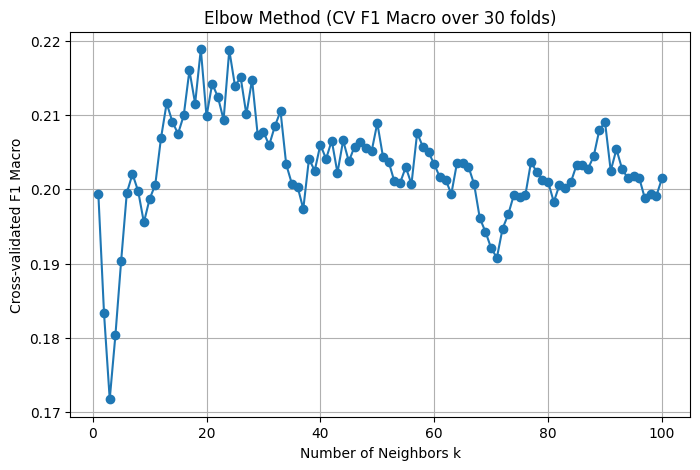

Best k by cross-validated F1 Macro: 19

Hold-out F1 Macro (k=19): 0.2227

Classification Report:
              precision    recall  f1-score   support

           3     0.5714    0.5405    0.5556        37
         100     0.4625    0.5211    0.4901        71
         300     0.1731    0.1800    0.1765        50
         500     0.1200    0.0638    0.0833        47
         700     0.1190    0.1163    0.1176        43
         900     0.2105    0.2000    0.2051        40
        1100     0.1154    0.0750    0.0909        40
        1300     0.1972    0.2333    0.2137        60
        1500     0.2000    0.3115    0.2436        61
        1700     0.1379    0.1026    0.1176        39
        1900     0.1667    0.1463    0.1558        41

    accuracy                         0.2420       529
   macro avg     0.2249    0.2264    0.2227       529
weighted avg     0.2319    0.2420    0.2337       529


Confusion Matrix:
[[20 11  2  1  1  1  0  1  0  0  0]
 [11 37 12  3  2  1  0  1  1  1  2]

In [34]:
def main(data_root, epochs=5, batch_size=32, lr=2e-4):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")




    
    full_ds = AdmixtureDataset(data_root)
    val_ratio = 0.2
    val_size = int(len(full_ds) * val_ratio)
    train_size = len(full_ds) - val_size
    train_ds, val_ds = split_dataset(full_ds, val_ratio=val_ratio)

    
    print(train_size)
    print(len(full_ds))

    
    
    full_loader = DataLoader(full_ds, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=False)
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=False)
    val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=False)


    
    model = CNNEmbedding(embedding_dim=128).to(device)
    opt = torch.optim.Adam(model.parameters(), lr=lr)

    train_semi_hard(model, train_loader, opt, device, val_loader=val_loader, k=23, epochs=epochs, mode='semi_hard')

    mode = "semi_hard"
    y_true, y_pred, _, f1_list = evaluate_knn_with_elbow_cv(model, full_ds, val_loader, device)


    for true, pred in zip(y_true[:10], y_pred[:10]):
        print(f"True: {true}, Predicted: {pred}")


    test_file_path = "jupyterLabGeneratedData\\per_bin_denisovan.txt"
    test_embedding = predict_single_file(model, test_file_path, device)

    val_embeddings = []
    val_labels = []
    model.eval()
    with torch.no_grad():
        for x_batch, y_batch in full_loader:
            x_batch = x_batch.to(device)
            embeds = model(x_batch)
            val_embeddings.append(embeds.cpu())
            val_labels.append(y_batch)

    val_embeddings = torch.cat(val_embeddings).numpy()
    val_labels = torch.cat(val_labels).numpy()

    knn = KNeighborsClassifier(n_neighbors=23)
    knn.fit(val_embeddings, val_labels)

#FINAL PREDICTION
    predicted_label = knn.predict(test_embedding.cpu().numpy())[0]
    print(f"Prediction: {predicted_label}")

if __name__ == "__main__":
    main(data_root="jupyterLabGeneratedData\\fullData", epochs=100, batch_size=128, lr=2e-5)